## 1. Setting Up the Environment

Before we dive into building our agent, we need to set up the necessary environment. This involves installing required packages and ensuring our Python environment is ready for development.

In [31]:
# Install termcolor for colored terminal outputs
%pip install termcolor langgraph

Note: you may need to restart the kernel to use updated packages.


In [32]:
# Import necessary libraries
from termcolor import colored
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import threading
import os
import time
from datetime import datetime, timezone
import logging

In [33]:
def get_disp_state(self,):
    current_state = self.graph.get_state(self.thread)
    lnode = current_state.values["lnode"]
    acount = current_state.values["count"]
    rev = current_state.values["revision_number"]
    nnode = current_state.next
    #print  (lnode,nnode,self.thread_id,rev,acount)
    return lnode,nnode,self.thread_id,rev,acount

def get_state(self,key):
    current_values = self.graph.get_state(self.thread)
    if key in current_values.values:
        lnode,nnode,self.thread_id,rev,astep = self.get_disp_state()
        new_label = f"last_node: {lnode}, thread_id: {self.thread_id}, rev: {rev}, step: {astep}"
        # return gr.update(label=new_label, value=current_values.values[key])
    else:
        return ""

def modify_state(self, key, asnode, new_state):
    """gets the current state, modifes a single value in the state identified by key, and updates state with it.
    note that this will create a new 'current state' node. If you do this multiple times with different keys, it will create
    one for each update. Note also that it doesn't resume after the update
    """
    current_values = self.graph.get_state(self.thread)
    current_values.values[key] = new_state
    self.graph.update_state(self.thread, current_values.values, as_node=asnode)
    return

## 3: Defining the Agent Graph State

In this step, we define the structure of the state that our agents will use to store and communicate information. This state acts as a shared memory that different components of the system can access and modify. We use the `TypedDict` from the `typing` module to define the expected structure and types of data within the state. This helps ensure consistency and correctness when accessing or updating the state, making it easier to manage complex workflows and data dependencies.

The `AgentGraphState` class includes fields for the research question, responses from the planner agent, and any final outputs or end states. The `get_agent_graph`_state function is used to retrieve specific parts of the state based on a key, facilitating modular and reusable access to the state data.

In [34]:
# Define the state object for the agent graph
class AgentGraphState(TypedDict):
    start_chain: Annotated[list, add_messages]
    transcription_response: Annotated[list, add_messages]
    end_chain: Annotated[list, add_messages]


# Function to retrieve specific parts of the agent state
def get_agent_graph_state(state: AgentGraphState, state_key: str):
    if state_key == "transcription_all":
        return state["transcription_response"]
    elif state_key == "transcription_latest":
        return (
            state["transcription_response"][-1]
            if state["transcription_response"]
            else []
        )

    else:
        return None


# Initial state setup
state = {
    "start_chain": [],
    "transcription_response": [],
    "end_chain": [],
}

## 4. Agent Class Definition

In this section, we define the `Agent` class, which serves as a base class for different types of agents in our system. An agent is a component that interacts with the language model to perform specific tasks, such as generating responses or processing information. The `Agent` class manages the configuration and state associated with the language model, allowing for easy setup and reuse of model configurations across different agents.

The class includes methods for initializing the agent with a specific model configuration and updating the agent's state. The state encapsulates the context or memory of the agent, enabling it to maintain continuity across interactions.

In [35]:
import threading


class Agent:
    def __init__(self, state: AgentGraphState):
        self.state = state
        self.lock = threading.Lock()

    def update_state(self, key: str, value: any):
        with self.lock:
            if key in self.state:
                self.state[key].append(value)
                print(
                    colored(
                        f"[update_state_FUNCTION][{key}] (size: {len(self.state[key])}): {self.state[key]}",
                        "magenta",
                    )
                )
            else:
                print(
                    f"Warning: Attempting to update a non-existing state key '{key}'."
                )

## 5. Utility Functions

Utility functions are auxiliary functions that assist with various common tasks within the notebook. They help keep the codebase clean and modular by encapsulating frequently used logic in separate functions. In this case, we have two utility functions: `check_for_content` and `get_current_utc_datetime`.

- `check_for_content`: This function checks if a variable has a content attribute and returns its value if it exists. This is useful for handling different data types that may or may not have a content attribute.
- `get_current_utc_datetime`: This function returns the current date and time in UTC format. This can be useful for timestamping events or logging.

In [36]:
# Get the current date and time in UTC
def get_current_utc_datetime():
    """
    Returns the current date and time in UTC.

    Returns:
    str: The current date and time in UTC, formatted as 'YYYY-MM-DD HH:MM:SS UTC'.
    """
    now_utc = datetime.now(timezone.utc)
    return now_utc.strftime("%Y-%m-%d %H:%M:%S.%f UTC")[:-3]  # Truncate to milliseconds

## 6. AudioAgent

In [37]:
class AudioAgent(Agent):
    def __init__(self, state: AgentGraphState, callback=None):
        super().__init__(state)
        self.callback = callback

    def record_audio(self):
        timestamp = get_current_utc_datetime()
        print(colored(f"START RECORDING {timestamp} 🎧", "cyan"))
        for _ in range(3):  # Change the range as needed
            timestamp = get_current_utc_datetime()
            file_name = f"{timestamp}.wav"
            print(colored(f"RECORDING at {timestamp} 🎧", "cyan"))
            self.update_state("transcription_response", file_name)
            if self.callback:
                self.callback(self.state)
            time.sleep(2)
        self.update_state("transcription_response", "END")
        if self.callback:
            self.callback(self.state)
        print(colored(f"STOP RECORDING at {timestamp} 🎧", "cyan"))

    def invoke(self) -> dict:
        print(colored(f"Audio STATE 📝: {self.state}", "cyan"))
        thread = threading.Thread(target=self.record_audio)
        thread.start()
        print(colored(f"STOP THREAD Audio 🎧", "cyan"))
        return self.state

In [38]:
# Define a callback function that handles the updated state
def handle_state_update(updated_state):
    print(colored("handle_state_update", "magenta"))
    # print("State updated:", updated_state)

In [39]:
class TranscriptAgent(Agent):

    def transcribe(self):
        timestamp = get_current_utc_datetime()
        print(colored(f"Transcript 📝: {timestamp}", "yellow"))

    def invoke(
        self, transcript,
    ) -> dict:
        print(colored(f"Transcript 📝: {transcript}", "yellow"))
        print(colored(f"Transcript STATE 📝: {self.state}", "yellow"))
        thread = threading.Thread(target=self.transcribe)
        thread.start()
        return self.state

## 7. End Node

The `EndNodeAgent` class is a specialized agent that marks the conclusion of the workflow in the agent graph. It extends the base `Agent` class and is primarily responsible for updating the state to indicate the end of the process. This agent is useful for workflows that require a clear termination point, ensuring that the system knows when all processing is complete.

In [40]:
class EndNodeAgent(Agent):
    def invoke(self) -> AgentGraphState:
        """
        Marks the end of the workflow by updating the state.

        This method updates the 'end_chain' key in the state to signify that
        the workflow has reached its conclusion. It can be used to perform any
        finalization tasks or simply to denote that the agent has completed its role.

        Returns:
        AgentGraphState: The updated state of the agent.
        """
        self.update_state("end_chain", "end_chain")
        return self.state

In [41]:
class StartNodeAgent(Agent):
    def invoke(self) -> AgentGraphState:
        """
        Marks the end of the workflow by updating the state.

        This method updates the 'end_chain' key in the state to signify that
        the workflow has reached its conclusion. It can be used to perform any
        finalization tasks or simply to denote that the agent has completed its role.

        Returns:
        AgentGraphState: The updated state of the agent.
        """
        self.update_state("start_chain", "start_chain")
        return self.state

In [42]:
def should_continue(state: AgentGraphState):
    """
    Determines the next step in the workflow based on the agent's output.

    Parameters:
    data (dict): The data containing the agent's state.

    Returns:
    str: The next node to execute ('continue' for tool execution, 'end' to finish).
    """
    recording = state["transcription_response"]
    print(
        colored(
            f"[SHOULD_CONTINUE_FUNCTION][RECORDING] (size: {len(recording)}): {recording}",
            "magenta",
        )
    )

    # Determine the next step based on the verification status
    if recording:
        if recording[-1] == "END":
            print(colored(f"Recording has finished", "red"))
            return "end"
        else:
            # print(colored(f"RECORDING STATE: {recording[-1].content}", "green"))
            print(colored(f"Still recording...", "green"))
            time.sleep(1)
            return "transcript"
    else:
        # print(colored(f"RECORDING STATE: {recording}", "yellow"))
        print(colored(f"No recording data available", "yellow"))
        time.sleep(1)
        return "transcript"

## 8. Creating and Compiling the Agent Graph

In this section, we define the structure and flow of the agent-based system using the `StateGraph` class from the `langgraph` library. The graph consists of nodes, each representing a specific agent, and edges, which define the flow or sequence of operations. This setup enables the modeling of complex workflows where different agents can interact and pass information.

- **`create_graph`:** This function initializes the `StateGraph` with a specific state structure (`AgentGraphState`). It then adds nodes for the `PlannerAgent` and `EndNodeAgent`, specifying the operations these agents should perform. The function sets the "planner" node as the entry point and the "end" node as the finish point, with an edge connecting them to define the workflow sequence.
- **`compile_workflow`:** This function compiles the defined graph into a workflow that can be executed. The compiled workflow manages the execution of the nodes in the defined order, handling the flow of data and control through the system.


In [43]:
from langgraph.graph import StateGraph, END

def create_graph() -> StateGraph:
    graph = StateGraph(AgentGraphState)

    graph.add_node(
        "start",
        lambda state: StartNodeAgent(
            state=state,
        ).invoke(),
    )

    graph.add_node(
        "audio_node",
        lambda state: AudioAgent(
            state=state,
            callback=handle_state_update,
        ).invoke(),
    )

    graph.add_node(
        "transcript_node",
        lambda state: TranscriptAgent(
            state=state,
        ).invoke(
            transcript=get_agent_graph_state(
                state=state, state_key="transcription_response"
            )
        ),
    )

    graph.add_node(
        "end",
        lambda state: EndNodeAgent(
            state=state,
        ).invoke(),
    )

    # Set the entry and finish points for the workflow
    graph.set_entry_point("start")
    graph.set_finish_point("end")

    # Define the flow of the graph
    graph.add_edge("start", "audio_node")
    graph.add_edge("start", "transcript_node")

    graph.add_conditional_edges(
        "transcript_node",
        should_continue,
        {"transcript": "transcript_node", "end": "end"},
    )
    # graph.add_edge("audio_node", "end")

    return graph


def compile_workflow(graph: StateGraph):
    workflow = graph.compile()
    return workflow

Graph and workflow created.


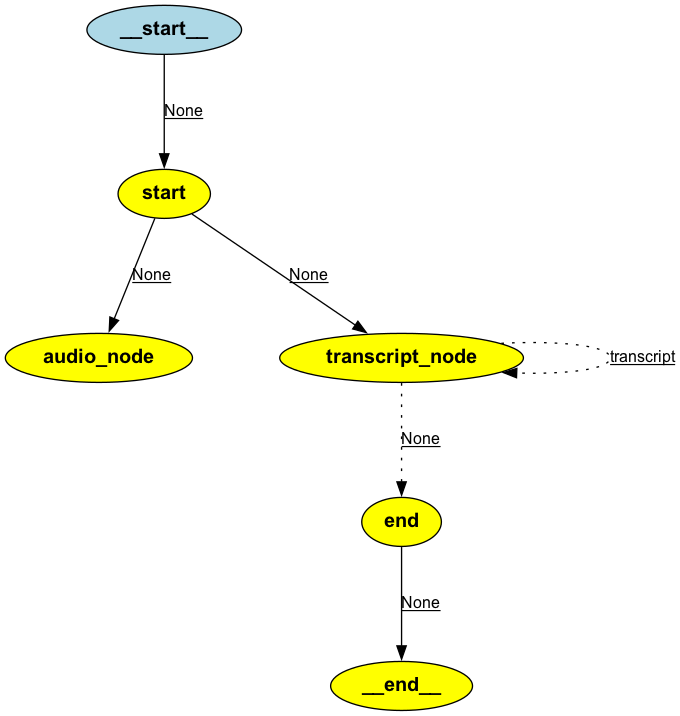

In [44]:
from IPython.display import Image, display

# Create the graph and compile the workflow
graph = create_graph()
workflow = compile_workflow(graph)
print("Graph and workflow created.")


display(Image(workflow.get_graph().draw_png()))

In [47]:
# Define workflow parameters
iterations = 10
thread = {"configurable": {"thread_id": "4"}}
verbose = True
dict_inputs = {"start_chain": "start"}
limit = {"recursion_limit": iterations}

# Execute the workflow and print state changes
async for event in workflow.astream_events(dict_inputs, config=thread, version="v2"):
    if verbose:
        print("\nState Dictionary:", event)
    else:
        print("\n")


State Dictionary: {'event': 'on_chain_start', 'data': {'input': {'start_chain': 'start'}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'bcc2b0e5-63eb-4273-a86c-eba63bea9c5d', 'metadata': {'thread_id': '4'}, 'parent_ids': []}

State Dictionary: {'event': 'on_chain_start', 'data': {'input': {'start_chain': 'start'}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'run_id': '19801e02-fa3f-4a3b-b258-8b297275835c', 'metadata': {'thread_id': '4', 'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ['__start__'], 'langgraph_task_idx': 0, 'thread_ts': '1ef50cd8-6a31-6a84-bffe-497aaa5a1d26'}, 'parent_ids': ['bcc2b0e5-63eb-4273-a86c-eba63bea9c5d']}

State Dictionary: {'event': 'on_chain_end', 'data': {'output': {'start_chain': 'start'}, 'input': {'start_chain': 'start'}}, 'run_id': '19801e02-fa3f-4a3b-b258-8b297275835c', 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'thread_id': '4', 'langgraph_step': 0, 'langgraph_node'

CancelledError: 